# London Modelling

In [28]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from scipy.stats import gaussian_kde
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as fm
%config InlineBackend.figure_format = 'retina'
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import matplotlib.font_manager as fm
import xgboost as xgb
import shap

# Load Cambria font
cambria_path = "/Library/Fonts/Microsoft/Cambria.ttf"  # Adjust path if needed
cambria_prop = fm.FontProperties(fname=cambria_path)

## 1. Import Data

In [2]:
# Import data
london_airbnb = gpd.read_file('../../data/london/airbnb_per_london_glx.gpkg')
london_tourism_fs = gpd.read_file('../../data/london/london_glx_tourism_pois.gpkg')

In [3]:
# Merge the two datasets on glx_id keeping only one geometry column
london_airbnb_tourism_fs = london_tourism_fs.merge(london_airbnb, on='glx_id', how='left')

# Drop geometry_x and rename geometry_y to geometry
london_airbnb_tourism_fs.drop(columns=['geometry_x'], inplace=True)
london_airbnb_tourism_fs.rename(columns={'geometry_y': 'geometry'}, inplace=True)

In [4]:
london_airbnb_tourism_fs.columns

Index(['glx_id', 'Airport/Heliport', 'Bakery/Patisserie', 'Bar (General)',
       'Beach', 'Beer Bar/Garden', 'Bike Rental', 'Brewery/Distillery',
       'Bridge', 'Bus Stop',
       ...
       'density_m2', 'density_km2', 'num_properties_log', 'density_m2_log',
       'density_km2_log', 'total_revenue_log', 'total_volume_log',
       'total_tourism_intensity_km2', 'total_tourism_intensity_km2_log',
       'geometry'],
      dtype='object', length=226)

In [5]:
# Create total_pois_log column
london_airbnb_tourism_fs['total_pois_log'] = np.log1p(london_airbnb_tourism_fs['total_pois'])

## 2. Data Exploration

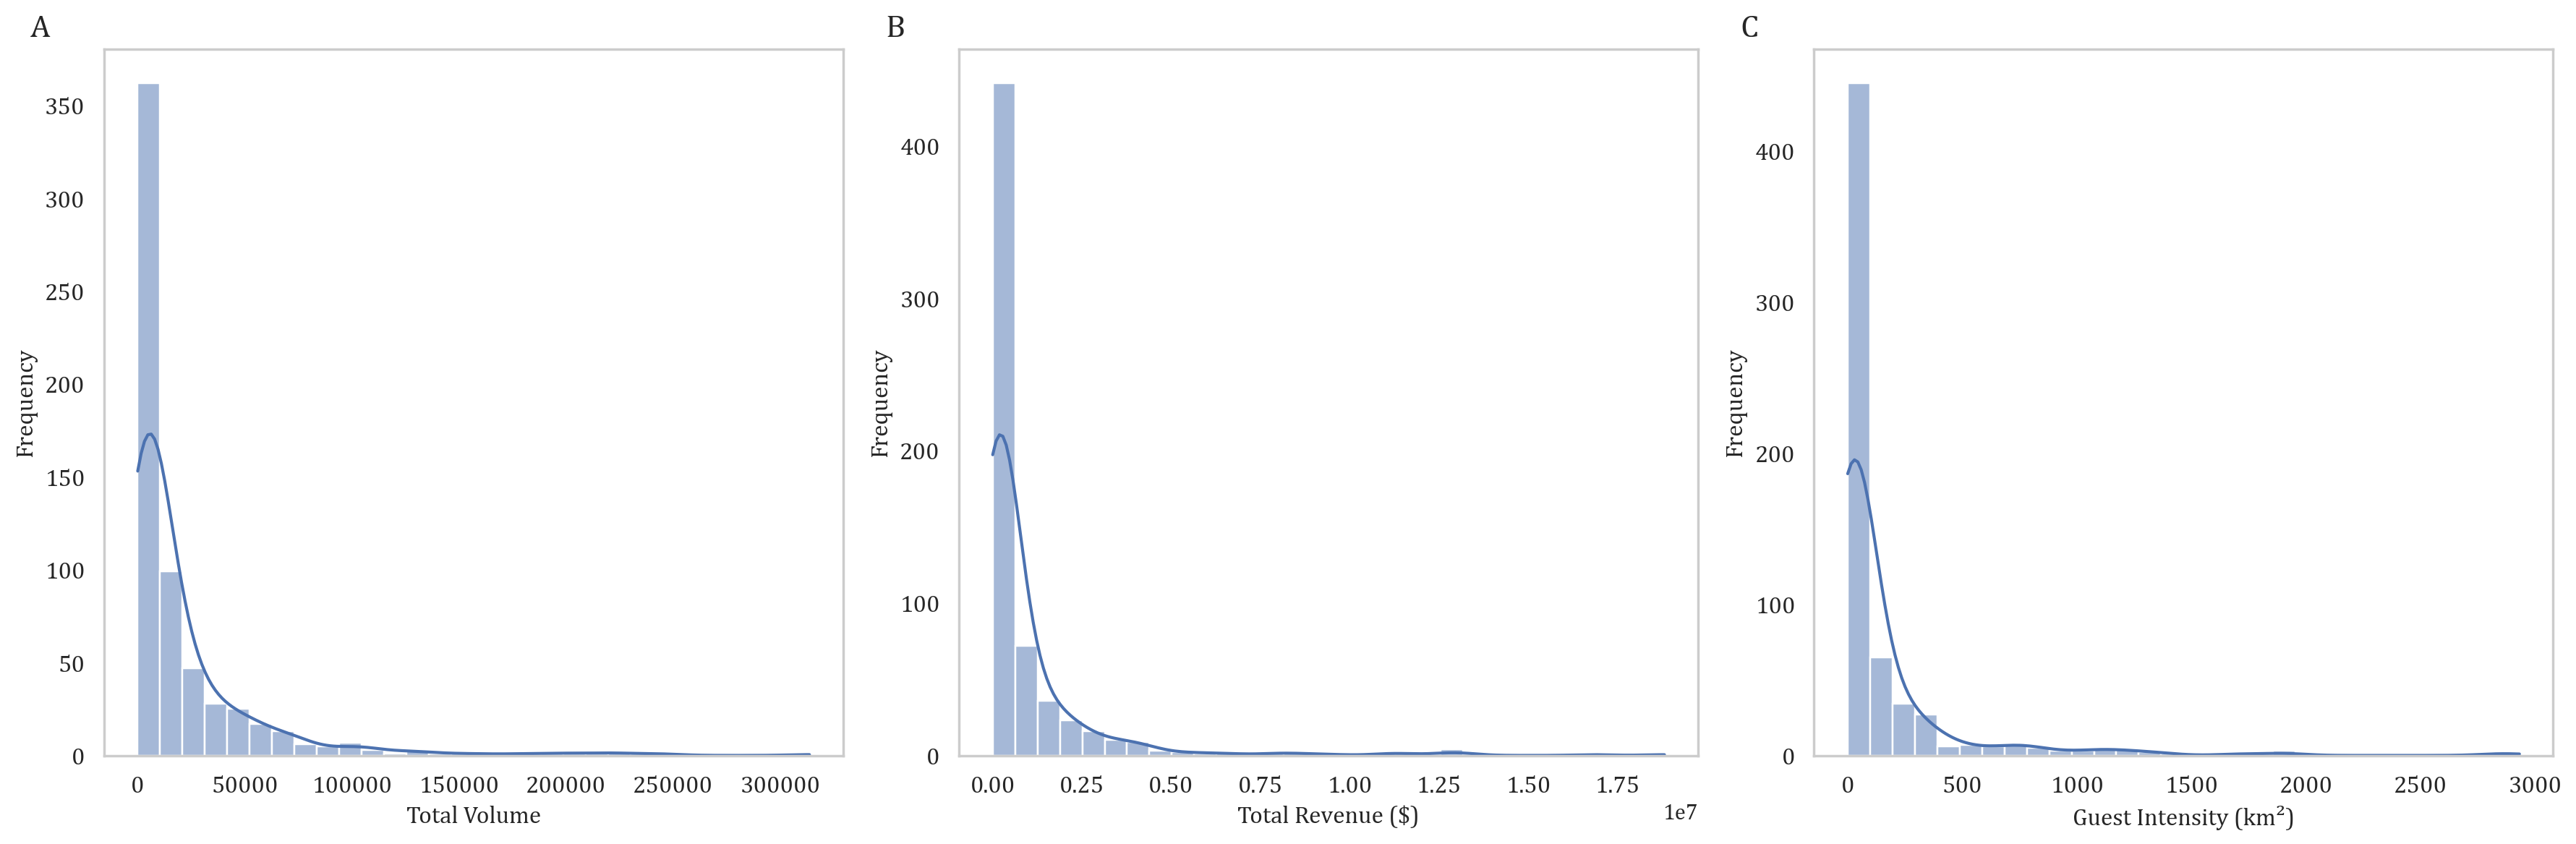

In [ ]:
# Create plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Total Volume
sns.histplot(london_airbnb_tourism_fs['total_volume'], bins=30, kde=True, ax=axes[0])
axes[0].set_xlabel('Total Volume', fontproperties=cambria_prop)
axes[0].set_ylabel('Frequency', fontproperties=cambria_prop)

# Plot 2: Total Revenue
sns.histplot(london_airbnb_tourism_fs['total_revenue'], bins=30, kde=True, ax=axes[1])
axes[1].set_xlabel('Total Revenue ($)', fontproperties=cambria_prop)
axes[1].set_ylabel('Frequency', fontproperties=cambria_prop)

# Plot 3: Tourism Intensity
sns.histplot(london_airbnb_tourism_fs['total_tourism_intensity_km2'], bins=30, kde=True, ax=axes[2])
axes[2].set_xlabel('Guest Intensity (km²)', fontproperties=cambria_prop)
axes[2].set_ylabel('Frequency', fontproperties=cambria_prop)

# Add A–C panel tags
panel_labels = ['A', 'B', 'C']
for i, ax in enumerate(axes):
    ax.text(
        -0.1, 1.05,
        panel_labels[i],
        transform=ax.transAxes,
        fontsize=16,
        fontproperties=cambria_prop,
        fontweight='bold',
        va='top',
        ha='left'
    ),
    ax.grid(False)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(cambria_prop)

plt.tight_layout()
plt.show()

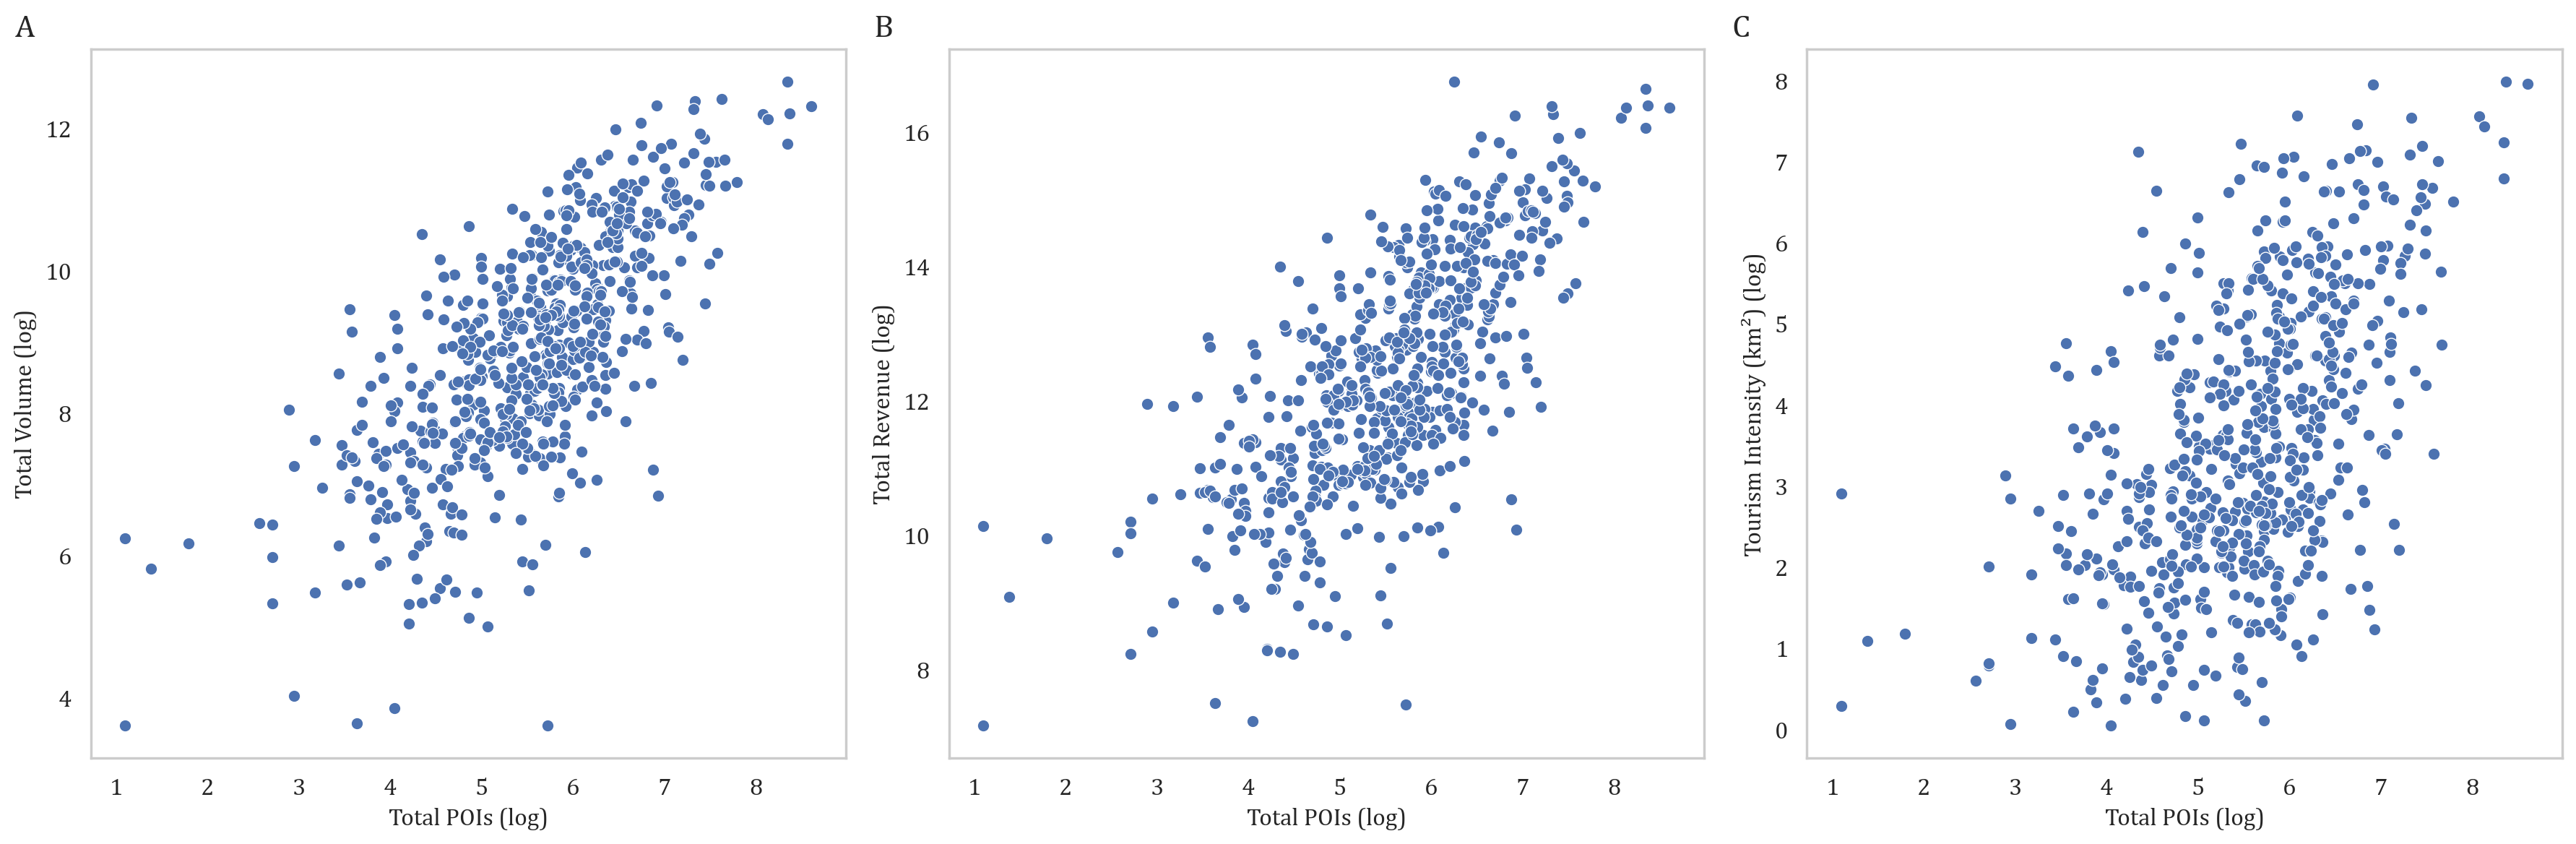

In [41]:
# Create three scatter plots showing total_pois vs, total_volume, total_revenue, and total_tourism_intensity_km2
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=london_airbnb_tourism_fs, x='total_pois_log', y='total_volume_log', ax=axes[0])
axes[0].set_xlabel('Total POIs (log)', fontproperties=cambria_prop)
axes[0].set_ylabel('Total Volume (log)', fontproperties=cambria_prop)

sns.scatterplot(data=london_airbnb_tourism_fs, x='total_pois_log', y='total_revenue_log', ax=axes[1])
axes[1].set_xlabel('Total POIs (log)', fontproperties=cambria_prop)
axes[1].set_ylabel('Total Revenue (log)', fontproperties=cambria_prop)

sns.scatterplot(data=london_airbnb_tourism_fs, x='total_pois_log', y='total_tourism_intensity_km2_log', ax=axes[2])
axes[2].set_xlabel('Total POIs (log)', fontproperties=cambria_prop)
axes[2].set_ylabel('Tourism Intensity (km²) (log)', fontproperties=cambria_prop)

# Add A–C panel tags
panel_labels = ['A', 'B', 'C']
for i, ax in enumerate(axes):
    ax.text(
        -0.1, 1.05,
        panel_labels[i],
        transform=ax.transAxes,
        fontsize=16,
        fontproperties=cambria_prop,
        fontweight='bold',
        va='top',
        ha='left'
    ),
    ax.grid(False)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(cambria_prop)

plt.tight_layout()
plt.show()
